In [88]:
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels = dataiter.next()

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its
        reconstruction also a PyTorch Tensor
    '''

    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box-forced')

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(2))
    ax2.set_yticklabels(['Rose','Sunflower'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [61]:
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from torch.autograd import Variable
import time

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()
                               ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()
                               ])
#Load the training data
trainset = datasets.ImageFolder("flowers-dataset/train", transform=train_transforms)
testset = datasets.ImageFolder("flowers-dataset/test", transform=test_transforms)

#traindata = torch.utils.data.DataLoader(trainset, batch_size=64, )
traindata = torch.utils.data.DataLoader(trainset, batch_size=32)
testdata = torch.utils.data.DataLoader(testset, batch_size=32)

<class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])
torch.Size([32])


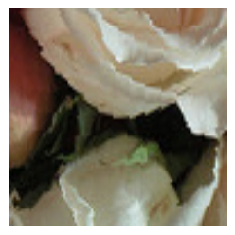

In [62]:
# A little test
images, labels = next(iter(traindata))
print(type(images))
print(images.shape)
print(labels.shape)
imshow(images[0], normalize=False)

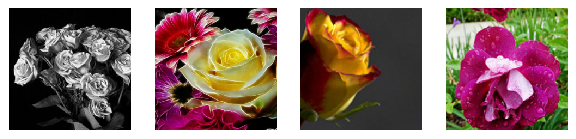

In [63]:
#An othertest
data_iter = iter(testdata)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize = (10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [66]:
#mode2 = models.densenet121(pretrained=True)
#mode2

In [67]:
# Turn off gradients for our modal
for param in model.parameters():
    param.requires_grad = False

In [70]:
#nn.Sequential(*list(model.children())[:cut]

classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.2),
                           nn.Linear(512, 2),
                           nn.LogSoftmax(dim=1))
model.fc = classifier

criterion = nn.NLLLoss()
optimization = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [81]:
epochs = 2
steps = 0
running_loss = 0
print_every = 5

In [83]:
for e in range(epochs):
    runing_loss = 0
    for images, labels in traindata: 
        steps += 1
        images, labels = images.to(device), labels.to(device)
        optimization.zero_grad()

        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimization.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()
            test_loss = 0
            accuracy = 0
            
            for images, labels in testdata:
                
                images, labels = images.to(device), labels.to(device)

                logps = model(images)
                loss = criterion(logps, labels)
                test_loss += loss.item()
                
                # Calculate the accuracy
                ps = torch.exp(logps)
                top_ps, top_class = ps.topk(1, dim=1)
                equality = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equality.type(torch.FloatTensor)).item()
            print("Epoch: ", epochs)
            print("Train loss:", (running_loss/print_every))
            print("Test loss:", (test_loss/len(testdata)))
            print("Test Accuracy:", (accuracy/len(testdata)))
            
            running_loss = 0
            model.train()
            
            

Epoch:  2
Train loss: 7.751230525970459
Test loss: 1.5600723197253852
Test Accuracy: 0.5192307692307693
Epoch:  2
Train loss: 2.264319658279419
Test loss: 1.584437604707021
Test Accuracy: 0.4807692307692308
Epoch:  2
Train loss: 1.8749697804450989
Test loss: 0.681602051624885
Test Accuracy: 0.7331730769230769
Epoch:  2
Train loss: 0.8352807641029358
Test loss: 0.6856071582207313
Test Accuracy: 0.6923076923076923
Epoch:  2
Train loss: 0.7163198232650757
Test loss: 0.6848779733364398
Test Accuracy: 0.5192307692307693


In [101]:
# Get our data
images, labels = next(iter(traindata))
print(images.shape)
#flatten images 1 , 784
img, labels = images.to(device), labels.to(device)
print(img.shape)
image = images.view(-1,images.shape)
print(image.shape)

#images.shape[0]

# image = images[0].view(1, 784)

with torch.no_grad():
    logits = model.forward(image)
ps = F.softmax(logits, dim=1)
view_classify(image,ps)

torch.Size([32, 3, 224, 224])
torch.Size([32, 3, 224, 224])


TypeError: view(): argument 'size' must be tuple of ints, but found element of type torch.Size at pos 2